In [77]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Paths

In [78]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# Set number of classes

In [79]:
NUM_CLASSES = 7

# Reading the DataSet

In [80]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [81]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model Building

In [83]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [84]:
model.summary()  
# tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_8 (Dropout)         (None, 42)                0         
                                                                 
 dense_12 (Dense)            (None, 20)                860       
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                210       
                                                                 
 dense_14 (Dense)            (None, 7)                 77        
                                                                 
Total params: 1,147
Trainable params: 1,147
Non-trainable params: 0
_________________________________________________________________


In [85]:

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [86]:
# Model Compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [87]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/7 [===>..........................] - ETA: 9s - loss: 2.0717 - accuracy: 0.0859
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
7/7 [==============================] - 2s 76ms/step - loss: 2.0053 - accuracy: 0.1321 - val_loss: 1.9148 - val_accuracy: 0.1293
Epoch 2/1000
1/7 [===>..........................] - ETA: 0s - loss: 1.9984 - accuracy: 0.1562
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
7/7 [==============================] - 0s 14ms/step - loss: 1.9734 - accuracy: 0.1385 - val_loss: 1.8823 - val_accuracy: 0.1217
Epoch 3/1000
1/7 [===>..........................] - ETA: 0s - loss: 1.9930 - accuracy: 0.1250
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
7/7 [==============================] - 0s 13ms/step - loss: 1.9289 - accuracy: 0.1766 - val_loss: 1.8542 - val_accuracy: 0.2357
Epoch 4/1000
1/7 [===>..........................] - ETA: 0s - loss: 1.9135 - accuracy: 0.2344
Epoch 4: sav

In [88]:
# Evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

3/3 [==============================] - 0s 4ms/step - loss: 0.5708 - accuracy: 0.7605


In [89]:
# Loading the model
model = tf.keras.models.load_model(model_save_path)

In [90]:
# Prediction
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 105ms/step
[5.7349138e-05 4.5759450e-03 7.5383991e-04 2.7152625e-01 4.9331850e-01
 1.8740238e-01 4.2365685e-02]
4


# Confusion Matrix

9/9 [==============================] - 0s 1ms/step


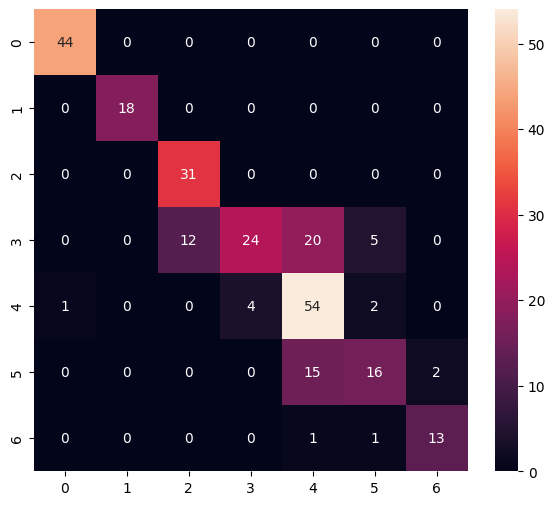

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        44
           1       1.00      1.00      1.00        18
           2       0.72      1.00      0.84        31
           3       0.86      0.39      0.54        61
           4       0.60      0.89      0.72        61
           5       0.67      0.48      0.56        33
           6       0.87      0.87      0.87        15

    accuracy                           0.76       263
   macro avg       0.81      0.80      0.79       263
weighted avg       0.79      0.76      0.74       263



In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [92]:
# Save the model
model.save(model_save_path, include_optimizer=False)

In [93]:
# Transform the model to tflite
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Dhanuja\AppData\Local\Temp\tmpc0mftz0p\assets


INFO:tensorflow:Assets written to: C:\Users\Dhanuja\AppData\Local\Temp\tmpc0mftz0p\assets


6740

# Inference test

In [94]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [95]:

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [96]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [97]:
%%time

interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [98]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.7349102e-05 4.5759464e-03 7.5384014e-04 2.7152613e-01 4.9331868e-01
 1.8740232e-01 4.2365652e-02]
4
